# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [8]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

from keras.models import Sequential
from keras.layers import Dense, Activation

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [12]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [13]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

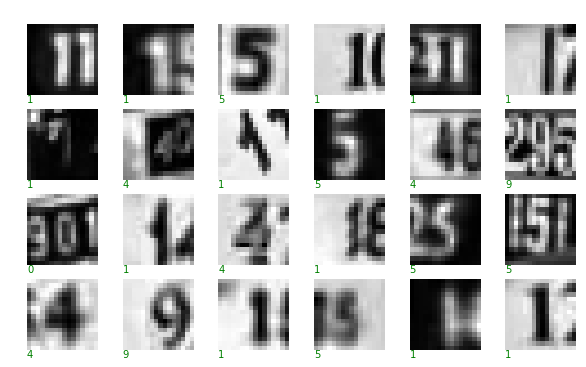

In [14]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [15]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [41]:
model = Sequential([
    Dense(32, input_shape=(256,)),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=1500, validation_split=0.2, batch_size=128, verbose=1)

Train on 30246 samples, validate on 7562 samples
Epoch 1/1500
30246/30246 [==============================] - 1s 23us/step - loss: 1.6074 - acc: 0.2228 - val_loss: 1.5612 - val_acc: 0.1263
Epoch 2/1500
30246/30246 [==============================] - 0s 15us/step - loss: 1.5913 - acc: 0.2636 - val_loss: 1.5823 - val_acc: 0.0664
Epoch 3/1500
30246/30246 [==============================] - 0s 16us/step - loss: 1.5848 - acc: 0.2718 - val_loss: 1.5252 - val_acc: 0.2017
Epoch 4/1500
30246/30246 [==============================] - 1s 29us/step - loss: 1.5793 - acc: 0.2827 - val_loss: 1.5594 - val_acc: 0.1128
Epoch 5/1500
30246/30246 [==============================] - 1s 23us/step - loss: 1.5737 - acc: 0.2911 - val_loss: 1.5526 - val_acc: 0.1448
Epoch 6/1500
30246/30246 [==============================] - 0s 16us/step - loss: 1.5678 - acc: 0.3021 - val_loss: 1.5403 - val_acc: 0.1357
Epoch 7/1500
30246/30246 [==============================] - 1s 17us/step - loss: 1.5613 - acc: 0.3053 - val_loss: 1.5

30246/30246 [==============================] - 1s 21us/step - loss: 0.9323 - acc: 0.7124 - val_loss: 0.9092 - val_acc: 0.7665
Epoch 60/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.9252 - acc: 0.7136 - val_loss: 0.8981 - val_acc: 0.7678
Epoch 61/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.9186 - acc: 0.7164 - val_loss: 0.8155 - val_acc: 0.8133
Epoch 62/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.9121 - acc: 0.7181 - val_loss: 0.8115 - val_acc: 0.8129
Epoch 63/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.9060 - acc: 0.7215 - val_loss: 0.8802 - val_acc: 0.7715
Epoch 64/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.8998 - acc: 0.7228 - val_loss: 0.7939 - val_acc: 0.8151
Epoch 65/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.8940 - acc: 0.7246 - val_loss: 0.8156 - val_acc: 0.8006
Epoch 66/1500
30246/30246 [=======

30246/30246 [==============================] - 0s 15us/step - loss: 0.7312 - acc: 0.7795 - val_loss: 0.7292 - val_acc: 0.8027
Epoch 118/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.7290 - acc: 0.7799 - val_loss: 0.6972 - val_acc: 0.8130
Epoch 119/1500
30246/30246 [==============================] - 1s 32us/step - loss: 0.7278 - acc: 0.7802 - val_loss: 0.6737 - val_acc: 0.8286
Epoch 120/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.7258 - acc: 0.7817 - val_loss: 0.7055 - val_acc: 0.8174
Epoch 121/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.7242 - acc: 0.7823 - val_loss: 0.6066 - val_acc: 0.8600
Epoch 122/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.7227 - acc: 0.7830 - val_loss: 0.6791 - val_acc: 0.8260
Epoch 123/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.7211 - acc: 0.7834 - val_loss: 0.6758 - val_acc: 0.8273
Epoch 124/1500
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.6557 - acc: 0.8037 - val_loss: 0.6464 - val_acc: 0.8350
Epoch 176/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6549 - acc: 0.8041 - val_loss: 0.5778 - val_acc: 0.8635
Epoch 177/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6537 - acc: 0.8052 - val_loss: 0.5921 - val_acc: 0.8555
Epoch 178/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6526 - acc: 0.8041 - val_loss: 0.5949 - val_acc: 0.8577
Epoch 179/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6520 - acc: 0.8054 - val_loss: 0.6110 - val_acc: 0.8483
Epoch 180/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6509 - acc: 0.8060 - val_loss: 0.6535 - val_acc: 0.8294
Epoch 181/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6495 - acc: 0.8051 - val_loss: 0.6373 - val_acc: 0.8376
Epoch 182/1500
30246/30246 [

30246/30246 [==============================] - 1s 21us/step - loss: 0.6046 - acc: 0.8211 - val_loss: 0.5735 - val_acc: 0.8604
Epoch 234/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6035 - acc: 0.8200 - val_loss: 0.5932 - val_acc: 0.8518
Epoch 235/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6025 - acc: 0.8218 - val_loss: 0.5166 - val_acc: 0.8823
Epoch 236/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6022 - acc: 0.8218 - val_loss: 0.4937 - val_acc: 0.8924
Epoch 237/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6014 - acc: 0.8221 - val_loss: 0.5657 - val_acc: 0.8631
Epoch 238/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.6002 - acc: 0.8212 - val_loss: 0.5848 - val_acc: 0.8568
Epoch 239/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5997 - acc: 0.8228 - val_loss: 0.5651 - val_acc: 0.8652
Epoch 240/1500
30246/30246 [

30246/30246 [==============================] - 1s 18us/step - loss: 0.5624 - acc: 0.8350 - val_loss: 0.5160 - val_acc: 0.8812
Epoch 292/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.5617 - acc: 0.8357 - val_loss: 0.6136 - val_acc: 0.8440
Epoch 293/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.5612 - acc: 0.8354 - val_loss: 0.5862 - val_acc: 0.8545
Epoch 294/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5603 - acc: 0.8369 - val_loss: 0.5299 - val_acc: 0.8753
Epoch 295/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5595 - acc: 0.8364 - val_loss: 0.5261 - val_acc: 0.8764
Epoch 296/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5585 - acc: 0.8365 - val_loss: 0.5372 - val_acc: 0.8720
Epoch 297/1500
30246/30246 [==============================] - 1s 40us/step - loss: 0.5586 - acc: 0.8369 - val_loss: 0.5277 - val_acc: 0.8779
Epoch 298/1500
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.5260 - acc: 0.8483 - val_loss: 0.5897 - val_acc: 0.8520
Epoch 350/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5255 - acc: 0.8483 - val_loss: 0.5272 - val_acc: 0.8703
Epoch 351/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5248 - acc: 0.8484 - val_loss: 0.5298 - val_acc: 0.8696
Epoch 352/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5242 - acc: 0.8488 - val_loss: 0.4707 - val_acc: 0.8913
Epoch 353/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.5236 - acc: 0.8485 - val_loss: 0.5216 - val_acc: 0.8740
Epoch 354/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5230 - acc: 0.8483 - val_loss: 0.5594 - val_acc: 0.8638
Epoch 355/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.5230 - acc: 0.8492 - val_loss: 0.5268 - val_acc: 0.8748
Epoch 356/1500
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4949 - acc: 0.8584 - val_loss: 0.4786 - val_acc: 0.8879
Epoch 408/1500
30246/30246 [==============================] - 1s 22us/step - loss: 0.4940 - acc: 0.8585 - val_loss: 0.5151 - val_acc: 0.8748
Epoch 409/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4936 - acc: 0.8578 - val_loss: 0.4511 - val_acc: 0.8967
Epoch 410/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4933 - acc: 0.8579 - val_loss: 0.4979 - val_acc: 0.8795
Epoch 411/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4928 - acc: 0.8579 - val_loss: 0.5271 - val_acc: 0.8715
Epoch 412/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4923 - acc: 0.8588 - val_loss: 0.5286 - val_acc: 0.8699
Epoch 413/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4918 - acc: 0.8586 - val_loss: 0.5159 - val_acc: 0.8749
Epoch 414/1500
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4669 - acc: 0.8660 - val_loss: 0.5003 - val_acc: 0.8807
Epoch 466/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4665 - acc: 0.8654 - val_loss: 0.4738 - val_acc: 0.8861
Epoch 467/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4660 - acc: 0.8663 - val_loss: 0.4824 - val_acc: 0.8848
Epoch 468/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4650 - acc: 0.8662 - val_loss: 0.5016 - val_acc: 0.8769
Epoch 469/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4649 - acc: 0.8666 - val_loss: 0.4888 - val_acc: 0.8794
Epoch 470/1500
30246/30246 [==============================] - 1s 23us/step - loss: 0.4647 - acc: 0.8670 - val_loss: 0.4792 - val_acc: 0.8853
Epoch 471/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4642 - acc: 0.8668 - val_loss: 0.4532 - val_acc: 0.8931
Epoch 472/1500
30246/30246 [

Epoch 523/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4424 - acc: 0.8740 - val_loss: 0.4979 - val_acc: 0.8765
Epoch 524/1500
30246/30246 [==============================] - 1s 26us/step - loss: 0.4419 - acc: 0.8741 - val_loss: 0.4543 - val_acc: 0.8906
Epoch 525/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4414 - acc: 0.8744 - val_loss: 0.4811 - val_acc: 0.8818
Epoch 526/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4417 - acc: 0.8751 - val_loss: 0.4804 - val_acc: 0.8824
Epoch 527/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4409 - acc: 0.8740 - val_loss: 0.4930 - val_acc: 0.8786
Epoch 528/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4406 - acc: 0.8745 - val_loss: 0.4996 - val_acc: 0.8757
Epoch 529/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.4404 - acc: 0.8747 - val_loss: 0.4868 - val_acc: 0.8802
Epoch 530/150

Epoch 581/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4217 - acc: 0.8794 - val_loss: 0.4791 - val_acc: 0.8810
Epoch 582/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4213 - acc: 0.8801 - val_loss: 0.4577 - val_acc: 0.8901
Epoch 583/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4213 - acc: 0.8812 - val_loss: 0.4927 - val_acc: 0.8761
Epoch 584/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4206 - acc: 0.8806 - val_loss: 0.4554 - val_acc: 0.8897
Epoch 585/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4208 - acc: 0.8806 - val_loss: 0.5263 - val_acc: 0.8671
Epoch 586/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4201 - acc: 0.8807 - val_loss: 0.4390 - val_acc: 0.8949
Epoch 587/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.4197 - acc: 0.8820 - val_loss: 0.4322 - val_acc: 0.8991
Epoch 588/150

30246/30246 [==============================] - 1s 20us/step - loss: 0.4050 - acc: 0.8862 - val_loss: 0.4525 - val_acc: 0.8914
Epoch 640/1500
30246/30246 [==============================] - 1s 18us/step - loss: 0.4042 - acc: 0.8852 - val_loss: 0.4694 - val_acc: 0.8836
Epoch 641/1500
30246/30246 [==============================] - 1s 18us/step - loss: 0.4043 - acc: 0.8851 - val_loss: 0.4470 - val_acc: 0.8931
Epoch 642/1500
30246/30246 [==============================] - 1s 17us/step - loss: 0.4041 - acc: 0.8855 - val_loss: 0.4549 - val_acc: 0.8881
Epoch 643/1500
30246/30246 [==============================] - 1s 21us/step - loss: 0.4034 - acc: 0.8850 - val_loss: 0.4731 - val_acc: 0.8848
Epoch 644/1500
30246/30246 [==============================] - 1s 38us/step - loss: 0.4035 - acc: 0.8849 - val_loss: 0.4134 - val_acc: 0.9025
Epoch 645/1500
30246/30246 [==============================] - 1s 32us/step - loss: 0.4034 - acc: 0.8857 - val_loss: 0.4437 - val_acc: 0.8931
Epoch 646/1500
30246/30246 [

30246/30246 [==============================] - 0s 14us/step - loss: 0.3898 - acc: 0.8892 - val_loss: 0.4649 - val_acc: 0.8865
Epoch 698/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3899 - acc: 0.8890 - val_loss: 0.4282 - val_acc: 0.8999
Epoch 699/1500
30246/30246 [==============================] - 0s 14us/step - loss: 0.3893 - acc: 0.8892 - val_loss: 0.4159 - val_acc: 0.9008
Epoch 700/1500
30246/30246 [==============================] - 1s 37us/step - loss: 0.3893 - acc: 0.8895 - val_loss: 0.4179 - val_acc: 0.9024
Epoch 701/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3892 - acc: 0.8896 - val_loss: 0.4519 - val_acc: 0.8910
Epoch 702/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3891 - acc: 0.8892 - val_loss: 0.4883 - val_acc: 0.8803
Epoch 703/1500
30246/30246 [==============================] - 0s 14us/step - loss: 0.3886 - acc: 0.8892 - val_loss: 0.4491 - val_acc: 0.8900
Epoch 704/1500
30246/30246 [

30246/30246 [==============================] - 1s 18us/step - loss: 0.3772 - acc: 0.8933 - val_loss: 0.4343 - val_acc: 0.8959
Epoch 756/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3772 - acc: 0.8920 - val_loss: 0.4424 - val_acc: 0.8937
Epoch 757/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3768 - acc: 0.8937 - val_loss: 0.3964 - val_acc: 0.9097
Epoch 758/1500
30246/30246 [==============================] - 0s 14us/step - loss: 0.3766 - acc: 0.8924 - val_loss: 0.4754 - val_acc: 0.8836
Epoch 759/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3759 - acc: 0.8925 - val_loss: 0.4364 - val_acc: 0.8965
Epoch 760/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3760 - acc: 0.8932 - val_loss: 0.4108 - val_acc: 0.9033
Epoch 761/1500
30246/30246 [==============================] - 1s 25us/step - loss: 0.3761 - acc: 0.8929 - val_loss: 0.4562 - val_acc: 0.8894
Epoch 762/1500
30246/30246 [

30246/30246 [==============================] - 0s 16us/step - loss: 0.3661 - acc: 0.8965 - val_loss: 0.4396 - val_acc: 0.8951
Epoch 814/1500
30246/30246 [==============================] - 1s 29us/step - loss: 0.3662 - acc: 0.8955 - val_loss: 0.3941 - val_acc: 0.9084
Epoch 815/1500
30246/30246 [==============================] - 1s 25us/step - loss: 0.3655 - acc: 0.8968 - val_loss: 0.4372 - val_acc: 0.8972
Epoch 816/1500
30246/30246 [==============================] - 1s 25us/step - loss: 0.3654 - acc: 0.8965 - val_loss: 0.4289 - val_acc: 0.8958
Epoch 817/1500
30246/30246 [==============================] - 1s 17us/step - loss: 0.3655 - acc: 0.8960 - val_loss: 0.4730 - val_acc: 0.8823
Epoch 818/1500
30246/30246 [==============================] - 1s 19us/step - loss: 0.3656 - acc: 0.8958 - val_loss: 0.4175 - val_acc: 0.9016
Epoch 819/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3648 - acc: 0.8963 - val_loss: 0.4545 - val_acc: 0.8901
Epoch 820/1500
30246/30246 [

30246/30246 [==============================] - 1s 44us/step - loss: 0.3559 - acc: 0.8980 - val_loss: 0.4610 - val_acc: 0.8893
Epoch 872/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3556 - acc: 0.8982 - val_loss: 0.4441 - val_acc: 0.8933
Epoch 873/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3556 - acc: 0.8977 - val_loss: 0.4535 - val_acc: 0.8910
Epoch 874/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3551 - acc: 0.8985 - val_loss: 0.4422 - val_acc: 0.8945
Epoch 875/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3550 - acc: 0.8983 - val_loss: 0.4367 - val_acc: 0.8961
Epoch 876/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3550 - acc: 0.8988 - val_loss: 0.4628 - val_acc: 0.8893
Epoch 877/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3547 - acc: 0.8983 - val_loss: 0.4732 - val_acc: 0.8875
Epoch 878/1500
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.3464 - acc: 0.9013 - val_loss: 0.4514 - val_acc: 0.8934
Epoch 930/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3470 - acc: 0.9008 - val_loss: 0.4209 - val_acc: 0.9004
Epoch 931/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3466 - acc: 0.9014 - val_loss: 0.4388 - val_acc: 0.8965
Epoch 932/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3462 - acc: 0.9015 - val_loss: 0.4345 - val_acc: 0.8958
Epoch 933/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3461 - acc: 0.9010 - val_loss: 0.4595 - val_acc: 0.8904
Epoch 934/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3461 - acc: 0.9011 - val_loss: 0.3987 - val_acc: 0.9062
Epoch 935/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3460 - acc: 0.9003 - val_loss: 0.4820 - val_acc: 0.8819
Epoch 936/1500
30246/30246 [

30246/30246 [==============================] - 0s 16us/step - loss: 0.3386 - acc: 0.9035 - val_loss: 0.4316 - val_acc: 0.8966
Epoch 988/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3382 - acc: 0.9038 - val_loss: 0.4235 - val_acc: 0.8992
Epoch 989/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3382 - acc: 0.9045 - val_loss: 0.4799 - val_acc: 0.8826
Epoch 990/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3377 - acc: 0.9038 - val_loss: 0.4442 - val_acc: 0.8945
Epoch 991/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3380 - acc: 0.9041 - val_loss: 0.4528 - val_acc: 0.8920
Epoch 992/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3376 - acc: 0.9038 - val_loss: 0.4359 - val_acc: 0.8975
Epoch 993/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3375 - acc: 0.9033 - val_loss: 0.3803 - val_acc: 0.9105
Epoch 994/1500
30246/30246 [

Epoch 1045/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3312 - acc: 0.9056 - val_loss: 0.4458 - val_acc: 0.8934
Epoch 1046/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3309 - acc: 0.9055 - val_loss: 0.3968 - val_acc: 0.9057
Epoch 1047/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3305 - acc: 0.9057 - val_loss: 0.4435 - val_acc: 0.8926
Epoch 1048/1500
30246/30246 [==============================] - 1s 40us/step - loss: 0.3305 - acc: 0.9051 - val_loss: 0.4718 - val_acc: 0.8867
Epoch 1049/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3303 - acc: 0.9065 - val_loss: 0.4709 - val_acc: 0.8846
Epoch 1050/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3302 - acc: 0.9059 - val_loss: 0.4444 - val_acc: 0.8946
Epoch 1051/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3304 - acc: 0.9058 - val_loss: 0.3987 - val_acc: 0.9066
Epoch 

30246/30246 [==============================] - 0s 15us/step - loss: 0.3240 - acc: 0.9084 - val_loss: 0.4880 - val_acc: 0.8773
Epoch 1103/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3241 - acc: 0.9079 - val_loss: 0.4250 - val_acc: 0.8990
Epoch 1104/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3238 - acc: 0.9067 - val_loss: 0.4264 - val_acc: 0.8987
Epoch 1105/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3237 - acc: 0.9077 - val_loss: 0.4881 - val_acc: 0.8818
Epoch 1106/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3234 - acc: 0.9085 - val_loss: 0.3983 - val_acc: 0.9061
Epoch 1107/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3240 - acc: 0.9074 - val_loss: 0.4586 - val_acc: 0.8883
Epoch 1108/1500
30246/30246 [==============================] - 1s 26us/step - loss: 0.3235 - acc: 0.9070 - val_loss: 0.5011 - val_acc: 0.8774
Epoch 1109/1500
30246/

Epoch 1160/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3180 - acc: 0.9092 - val_loss: 0.4450 - val_acc: 0.8914
Epoch 1161/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3178 - acc: 0.9088 - val_loss: 0.4455 - val_acc: 0.8922
Epoch 1162/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3177 - acc: 0.9092 - val_loss: 0.4698 - val_acc: 0.8834
Epoch 1163/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3176 - acc: 0.9093 - val_loss: 0.4412 - val_acc: 0.8931
Epoch 1164/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3173 - acc: 0.9102 - val_loss: 0.3741 - val_acc: 0.9119
Epoch 1165/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3176 - acc: 0.9103 - val_loss: 0.4743 - val_acc: 0.8816
Epoch 1166/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3176 - acc: 0.9104 - val_loss: 0.4247 - val_acc: 0.8991
Epoch 

30246/30246 [==============================] - 0s 15us/step - loss: 0.3125 - acc: 0.9098 - val_loss: 0.4337 - val_acc: 0.8955
Epoch 1218/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3121 - acc: 0.9100 - val_loss: 0.4136 - val_acc: 0.8994
Epoch 1219/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3122 - acc: 0.9101 - val_loss: 0.3839 - val_acc: 0.9107
Epoch 1220/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3118 - acc: 0.9102 - val_loss: 0.3461 - val_acc: 0.9212
Epoch 1221/1500
30246/30246 [==============================] - 1s 49us/step - loss: 0.3123 - acc: 0.9101 - val_loss: 0.4809 - val_acc: 0.8809
Epoch 1222/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3120 - acc: 0.9106 - val_loss: 0.4168 - val_acc: 0.8990
Epoch 1223/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3114 - acc: 0.9110 - val_loss: 0.4640 - val_acc: 0.8875
Epoch 1224/1500
30246/

Epoch 1275/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3070 - acc: 0.9117 - val_loss: 0.4747 - val_acc: 0.8806
Epoch 1276/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3070 - acc: 0.9121 - val_loss: 0.3874 - val_acc: 0.9082
Epoch 1277/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3069 - acc: 0.9122 - val_loss: 0.4494 - val_acc: 0.8914
Epoch 1278/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3069 - acc: 0.9116 - val_loss: 0.4127 - val_acc: 0.9003
Epoch 1279/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3067 - acc: 0.9117 - val_loss: 0.3878 - val_acc: 0.9062
Epoch 1280/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3070 - acc: 0.9114 - val_loss: 0.4245 - val_acc: 0.8965
Epoch 1281/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3064 - acc: 0.9128 - val_loss: 0.4296 - val_acc: 0.8963
Epoch 

30246/30246 [==============================] - 0s 15us/step - loss: 0.3023 - acc: 0.9123 - val_loss: 0.4393 - val_acc: 0.8906
Epoch 1333/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3025 - acc: 0.9129 - val_loss: 0.4506 - val_acc: 0.8909
Epoch 1334/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.3019 - acc: 0.9127 - val_loss: 0.4384 - val_acc: 0.8937
Epoch 1335/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3017 - acc: 0.9133 - val_loss: 0.3989 - val_acc: 0.9048
Epoch 1336/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3021 - acc: 0.9133 - val_loss: 0.4374 - val_acc: 0.8939
Epoch 1337/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3018 - acc: 0.9137 - val_loss: 0.4600 - val_acc: 0.8888
Epoch 1338/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.3018 - acc: 0.9134 - val_loss: 0.4303 - val_acc: 0.8946
Epoch 1339/1500
30246/

Epoch 1390/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2978 - acc: 0.9143 - val_loss: 0.4134 - val_acc: 0.9020
Epoch 1391/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2980 - acc: 0.9137 - val_loss: 0.4358 - val_acc: 0.8942
Epoch 1392/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2977 - acc: 0.9135 - val_loss: 0.4148 - val_acc: 0.8988
Epoch 1393/1500
30246/30246 [==============================] - 0s 16us/step - loss: 0.2977 - acc: 0.9140 - val_loss: 0.4173 - val_acc: 0.8983
Epoch 1394/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2978 - acc: 0.9143 - val_loss: 0.4150 - val_acc: 0.9011
Epoch 1395/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2975 - acc: 0.9139 - val_loss: 0.4487 - val_acc: 0.8902
Epoch 1396/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2970 - acc: 0.9140 - val_loss: 0.4243 - val_acc: 0.8965
Epoch 

30246/30246 [==============================] - 1s 22us/step - loss: 0.2936 - acc: 0.9158 - val_loss: 0.4548 - val_acc: 0.8887
Epoch 1448/1500
30246/30246 [==============================] - 1s 26us/step - loss: 0.2939 - acc: 0.9157 - val_loss: 0.3710 - val_acc: 0.9107
Epoch 1449/1500
30246/30246 [==============================] - 1s 25us/step - loss: 0.2933 - acc: 0.9158 - val_loss: 0.4031 - val_acc: 0.9043
Epoch 1450/1500
30246/30246 [==============================] - 1s 22us/step - loss: 0.2933 - acc: 0.9155 - val_loss: 0.4040 - val_acc: 0.9041
Epoch 1451/1500
30246/30246 [==============================] - 1s 21us/step - loss: 0.2936 - acc: 0.9147 - val_loss: 0.4223 - val_acc: 0.8980
Epoch 1452/1500
30246/30246 [==============================] - 1s 32us/step - loss: 0.2936 - acc: 0.9149 - val_loss: 0.4459 - val_acc: 0.8914
Epoch 1453/1500
30246/30246 [==============================] - 0s 15us/step - loss: 0.2932 - acc: 0.9154 - val_loss: 0.4045 - val_acc: 0.9028
Epoch 1454/1500
30246/

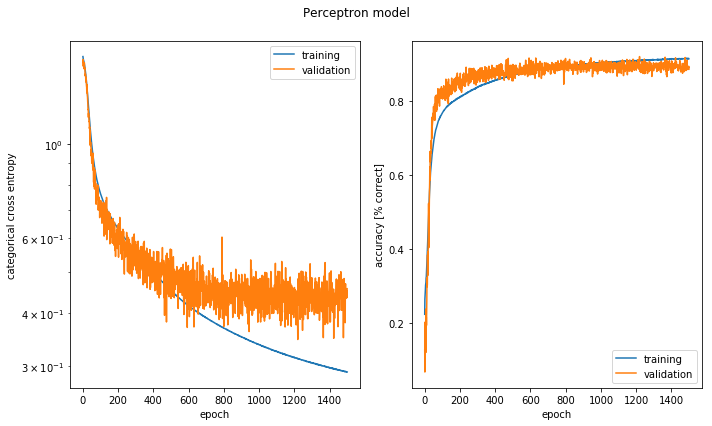

In [42]:
ph = plot_history(history, "Perceptron model")

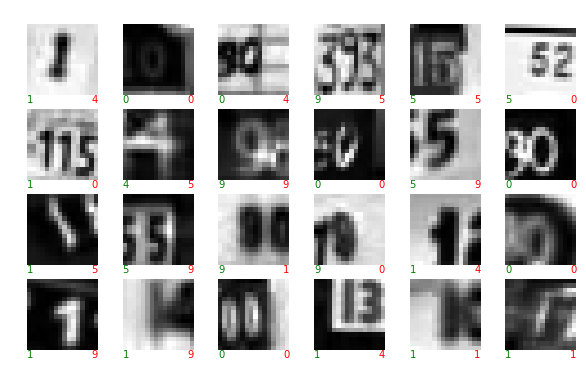

In [43]:
yhat_test= model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

ps = plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) 

B) 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution